In [1]:

import os
from tokenize import group
import numpy as np
import pandas as pd
import time
from math import radians, degrees, sin, cos, asin, acos, sqrt, atan2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import plotly.figure_factory as ff
import matplotlib.collections as mcoll
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from geopy.distance import geodesic
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib.ticker as mticker
import tcmarkers

import pickle  

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from skimage.measure import regionprops
from sklearn.decomposition import PCA

import scipy.ndimage as ndimage
from scipy.stats import gaussian_kde
from scipy.interpolate import interpn
from scipy.ndimage import binary_dilation, minimum_filter, maximum_filter, label
from scipy import integrate
from scipy.sparse import diags, kron
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cg

from datetime import datetime, timedelta

# import haversine
from haversine import haversine

import tropycal.tracks as tracks

from numba import jit

import itertools    

# from ty_pkg import latlon
from ty_pkg import truncate_colormap, colorline, setup_map, weather_map_contour, contourf_and_save, ep_t, concentric_circles, interpolate_data, set_map
from ty_pkg import latlon_extent, storm_info, haversine_distance, Met, calculate_bearing_position, tc_finder, WindFieldSolver, find_large_groups

pangu_dir = r'/home1/jek/Pangu-Weather'

pres_list = ['1000','925','850','700','600','500','400','300','250','200','150','100','50']
pres=500                                                #살펴볼 기압면 결정
p=pres_list.index(str(pres))
pres_array = np.array(pres_list, dtype=np.float32)

surface_factor = ['MSLP', 'U10', 'V10', 'T2M']
surface_dict = {'MSLP':0, 'U10':1, 'V10':2, 'T2M':3}
upper_factor = ['z', 'q', 't', 'u', 'v']
upper_dict = {'z':0, 'q':1, 't':2, 'u':3, 'v':4}

proj = ccrs.PlateCarree()
norm_p = mcolors.Normalize(vmin=950, vmax=1020)

# Define the colors you want in your colormap
colors = ["purple", "darkblue", "lightblue", "white", "yellow", "red", "pink"]

# Create a colormap from the colors
pwp = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)


#%%
#! 태풍 경로 정보 기존 정보 불러오기
#위경도 지정
lat_indices, lat_start, lat_end, lon_indices, lon_start, lon_end, extent, latlon_ratio = latlon_extent(100,160,5,45)  
lon_grid, lat_grid = np.meshgrid(lon_indices[lon_start:lon_end + 1], lat_indices[lat_start:lat_end + 1])


ssv_dict = {}


#태풍 지정
storm_name = 'hinnamnor'                                                                               
storm_name = storm_name.upper()
storm_year = 2022

surface_factors = []  # 예시: 지표면에서는 'MSLP'만 선택
upper_factors = ['z'] 
perturation_scale = 0.05

#예측 시간 지정, 초기 시간 지정, 앙상블 수
key_time_list = ['2022/08/27/00UTC']
predict_interval_list = np.arange(0,24*7+1,6)  
ens_list = range(0,4000)
new_ssv = 'n'           #새로 생성할 것인지 여부, n이면 기존 파일 불러옴
retro_opt = 'td'        #다시 돌아가면서 태풍 추적시 강한 것만 추적하려면 td로

if retro_opt =='td':
    retro_opt = '_td'
else:
    retro_opt = ''
        
#! 태풍 경로 정보 새로 생성하기
if new_ssv == 'y':
    for first_str in key_time_list:
        first_time = datetime.strptime(first_str, "%Y/%m/%d/%HUTC")
        key_str = first_time.strftime("%m.%d.%HUTC")
        ssv_key = first_time
        surface_factors.sort()
        upper_factors.sort()
        surface_str = "".join([f"_{factor}" for factor in surface_factors])  # 각 요소 앞에 _ 추가
        upper_str = "".join([f"_{factor}" for factor in upper_factors])  # 각 요소 앞에 _ 추가


        datetime_list = np.array([first_time + timedelta(hours=int(hours)) for hours in predict_interval_list])
        # datetime_array = np.array([(first_time + timedelta(hours=int(hours))) for hours in predict_interval_list])

        storm_lon, storm_lat, storm_mslp, storm_time = storm_info(pangu_dir, storm_name, storm_year, datetime_list = datetime_list, wind_thres=0)   #태풍 영문명, 년도 입력

        min_position = {}  # 태풍 중심 정보 dictionary



        # for ens in range(ens_num):
        for ens in ens_list:
            print(f'{ens}번째 앙상블 예측')
            min_position[ens] = {}
            output_data_dir = rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
            
            
            
            for predict_interval in predict_interval_list:
                predict_time = first_time + timedelta(hours=int(predict_interval))
                predict_str = predict_time.strftime("%Y/%m/%d/%HUTC")
                met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid)
                mslp = met.met_data('MSLP')
                wind_speed = met.wind_speed()
                z_diff = met.met_data('z', level = 300) - met.met_data('z', level = 500)
              
                #mask_size는 다음 태풍 찾을 때 그 위경도 안이 아니면 안 찾음S
                #처음 시작할 때는 5도 이내에만 들어오면 되고
                #mslp_z_dis는 250이 기본인데 이는 mslp 지역 최솟값과 z지역 최댓값이 250km 이내여야 pass
                #mslp_2hpa는 주변 8방위로 2hPa이 감소하는지 보는건데 일단은 'n'으로 걸어둠
                #아래에서는 mask_size말고는 아무런 제약을 안 걸었음
                min_position[ens] = tc_finder(mslp, lat_indices, lon_indices, lat_start, lon_start, lat_grid, lon_grid, 
                                        wind_speed, predict_time, z_diff, storm_lon, storm_lat, storm_mslp, storm_time, 
                                        min_position[ens], mask_size = 2.5, init_size=5, local_min_size = 5, mslp_z_dis = 250, wind_thres=8)

            
            for predict_interval in predict_interval_list[::-1]:
                predict_time = first_time + timedelta(hours=int(predict_interval))
                predict_str = predict_time.strftime("%Y/%m/%d/%HUTC")
                met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid)
                mslp = met.met_data('MSLP')
                wind_speed = met.wind_speed()
                z_diff = met.met_data('z', level = 300) - met.met_data('z', level = 500)
                
                if retro_opt != '_td':
                    min_position[ens] = tc_finder(mslp, lat_indices, lon_indices, lat_start, lon_start, lat_grid, lon_grid, 
                                                wind_speed, predict_time, z_diff, storm_lon, storm_lat, storm_mslp, storm_time, 
                                                min_position[ens], mask_size = 2.5, local_min_size = 5, back_prop='y', mslp_z_dis = 1000, wind_thres=8)
                else:
                    min_position[ens] = tc_finder(mslp, lat_indices, lon_indices, lat_start, lon_start, lat_grid, lon_grid, 
                                                wind_speed, predict_time, z_diff, storm_lon, storm_lat, storm_mslp, storm_time, 
                                                min_position[ens], mask_size = 2.5, local_min_size = 5, back_prop='y', mslp_z_dis = 250, wind_thres=8)
                    
                
                min_position[ens] = {k: min_position[ens][k] for k in sorted(min_position[ens])}
                
        ssv_dict[ssv_key] = min_position

    with open(rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'wb') as f:
        pickle.dump(ssv_dict, f)

else:
    for first_str in key_time_list:
        first_time = datetime.strptime(first_str, "%Y/%m/%d/%HUTC")
        key_str = first_time.strftime("%m.%d.%HUTC")
        ssv_key = first_time
        surface_factors.sort()
        upper_factors.sort()
        surface_str = "".join([f"_{factor}" for factor in surface_factors])  # 각 요소 앞에 _ 추가
        upper_str = "".join([f"_{factor}" for factor in upper_factors])  # 각 요소 앞에 _ 추가
        
        datetime_list = np.array([first_time + timedelta(hours=int(hours)) for hours in predict_interval_list])
        # datetime_array = np.array([(first_time + timedelta(hours=int(hours))) for hours in predict_interval_list])
        storm_lon, storm_lat, storm_mslp, storm_time = storm_info(pangu_dir, storm_name, storm_year, datetime_list = datetime_list, wind_thres=0)   #태풍 영문명, 년도 입력

        
        with open(rf'/data03/Pangu_TC_ENS/{perturation_scale}ENS{surface_str}{upper_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'rb') as f:
            ssv_dict = pickle.load(f)
        
# #%%
# #! 태풍 경로 그리기
# for key_time ,min_position in ssv_dict.items():
#     fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': proj})
#     key_str = key_time.strftime("%m.%d.%HUTC")
#     # ax.set_title(f'{key_time.strftime("%Y-%m-%d-%HUTC")} (+{predict_interval_list[-1]}h)', fontsize=20, loc = 'left')
#     # ax.set_title(f'ENS{surface_str}{upper_str}{perturation_scale} Track\n{storm_name}', fontsize=20, loc = 'right')
#     # ax.set_title(f'{storm_name}', fontsize=20, loc = 'right')
#     ax.set_extent([120,155,20,45], crs=proj)
#     setup_map(ax)

#     ax.plot(storm_lon, storm_lat, color='black', linestyle='-', marker='', label = 'Best track', transform=ax.projection, zorder=10)
#     model_pred_sc = ax.scatter(storm_lon, storm_lat, c=storm_mslp, cmap='jet_r', marker='^',norm=norm_p, transform=ax.projection, zorder=10)
#     cbar = plt.colorbar(model_pred_sc, ax=ax, orientation='vertical', label='MSLP (hPa)', shrink=0.8)
#     cbar.ax.tick_params(labelsize=15)

    
#     for i in range(len(storm_time)):
#         new_time = storm_time[i].strftime("%Y/%m/%d/%HUTC")
#         if new_time.endswith('00UTC'):
#             dx, dy = 5, -0.5  # 시간 나타낼 위치 조정
#             new_lon, new_lat = storm_lon[i] + dx, storm_lat[i] + dy
            
#             # annotate를 사용하여 텍스트와 함께 선(화살표)을 그림
#             ax.text(storm_lon[i], new_lat, new_time[8:-6]
#                     , horizontalalignment='right', verticalalignment='top', fontsize=15, zorder = 20, fontweight = 'bold')



#     # for ens in range(ens_num):  
#     for ens in ens_not_list[:10]:  


#         lons = [pos['lon'] for _,pos in min_position[ens].items()]
#         lats = [pos['lat'] for _,pos in min_position[ens].items()]
#         min_values = [pos['mslp'] for _,pos in min_position[ens].items()]
#         pred_times = [pos for pos,_ in min_position[ens].items()]
#         # print(ens)
#         lc = colorline(ax, lons, lats, z=min_values, cmap=plt.get_cmap('jet_r'), norm=mcolors.Normalize(vmin=950, vmax=1020), linewidth=2, alpha=1)

#         #? 시간 표시 00UTC만 표시, 없앨듯

#         # if ens == 0:
#         #     lc = colorline(ax, lons, lats, z=min_values, cmap=plt.get_cmap('jet_r'), norm=mcolors.Normalize(vmin=950, vmax=1020), linewidth=2, alpha=1)
#         #     ax.scatter(lons, lats, c='red', linewidth=2, alpha=1, zorder=10, label = 'No perturbation')

#         for i in range(len(pred_times)):
#             if pred_times[i].hour == 0:
#                 ax.text(lons[i],lats[i], str(pred_times[i].day)
#                     , horizontalalignment='center', verticalalignment='bottom', fontsize=10, zorder = 6)

        
#     ax.legend(loc='upper right')


#     lons_all = np.concatenate([np.array([pos['lon'] for _, pos in min_position[ens].items()]) for ens in ens_list])
#     lats_all = np.concatenate([np.array([pos['lat'] for _, pos in min_position[ens].items()]) for ens in ens_list])


#     xy = np.vstack([lons_all, lats_all])
#     kde = gaussian_kde(xy)
#     positions = np.vstack([lon_grid.ravel(), lat_grid.ravel()])
#     f = np.reshape(kde(positions).T, lon_grid.shape)


#     levels = np.linspace(0.0005, 0.015, 100)
#     # cf = ax.contourf(lon_grid, lat_grid, f, levels=levels, transform=proj, cmap='jet')
#     plt.show()
#     # fig.savefig(f'{pangu_dir}/plot/Ensemble_track_{key_str}.png',bbox_inches='tight')
    

/home1/jek/miniconda3/envs/pangu/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [11]:
np.shape(near_map['u'])

(161, 241)

2529 1471
0 12
6 32
12 391
18 1113
24 2753
30 3709
36 3995
42 3998
48 4000
54 4000
60 4000
66 3987
72 3987
78 3987
84 3979
90 3814
96 3806
102 3779
108 3751
114 3669
120 3594


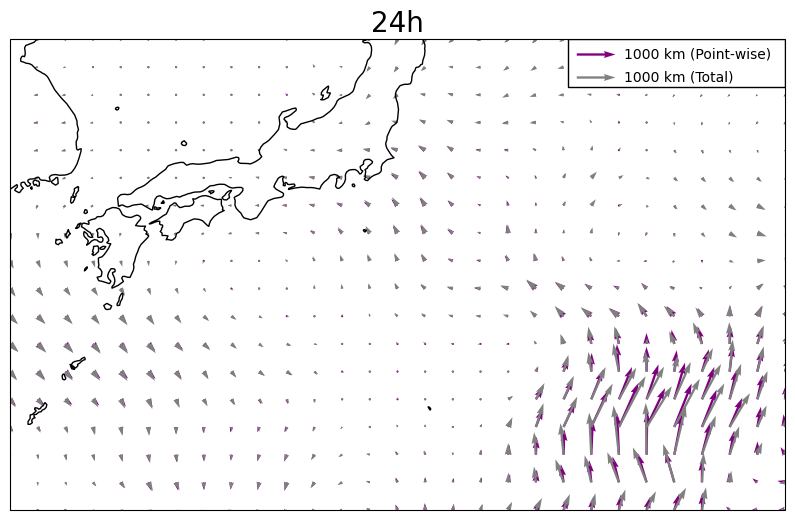

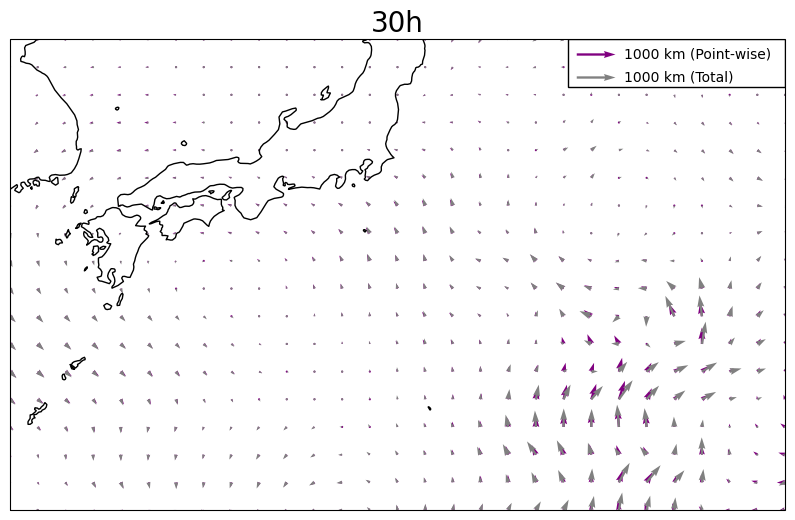

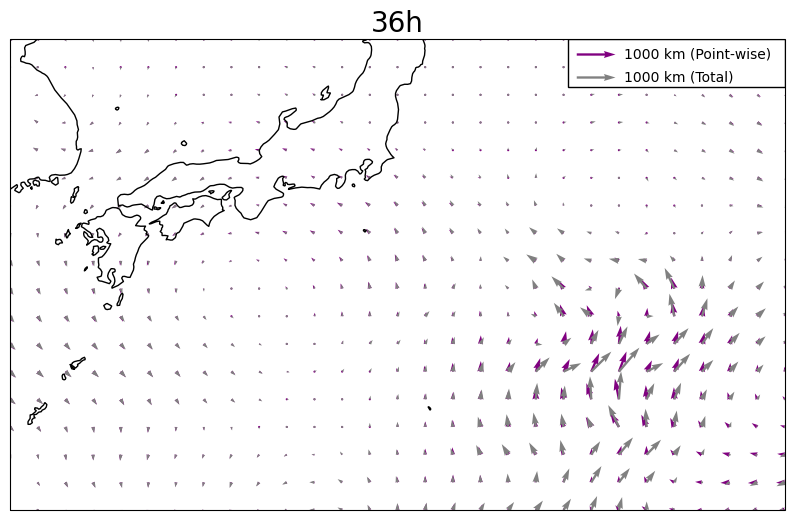

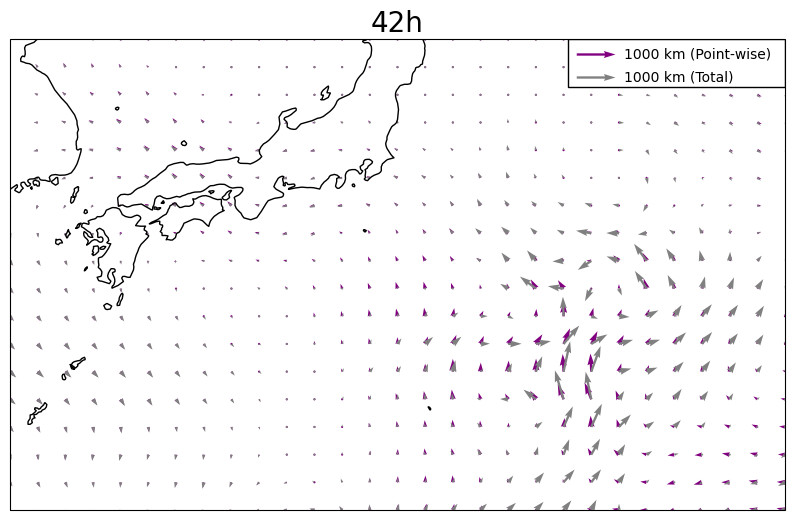

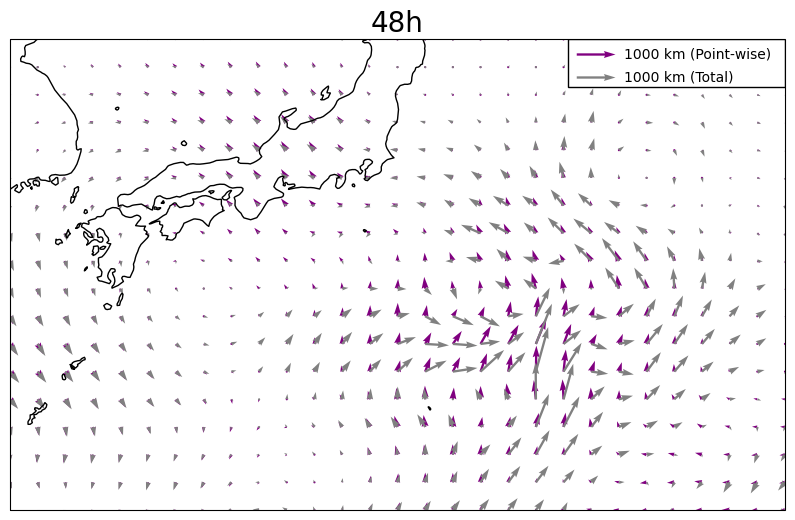

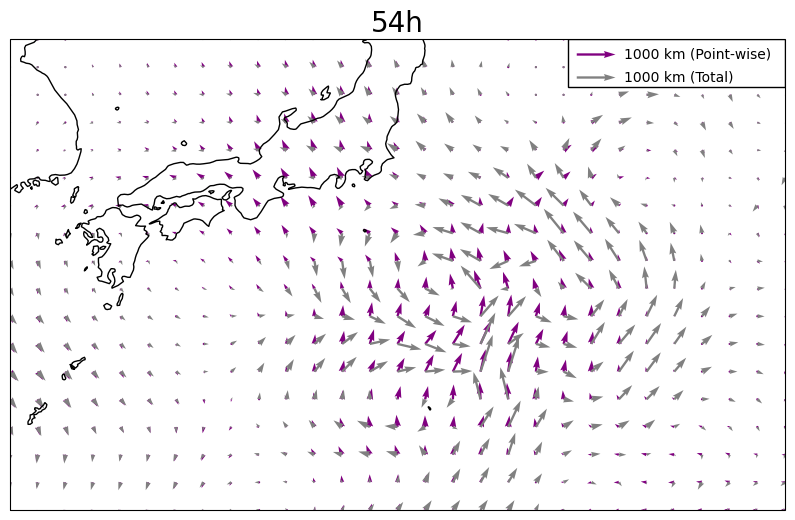

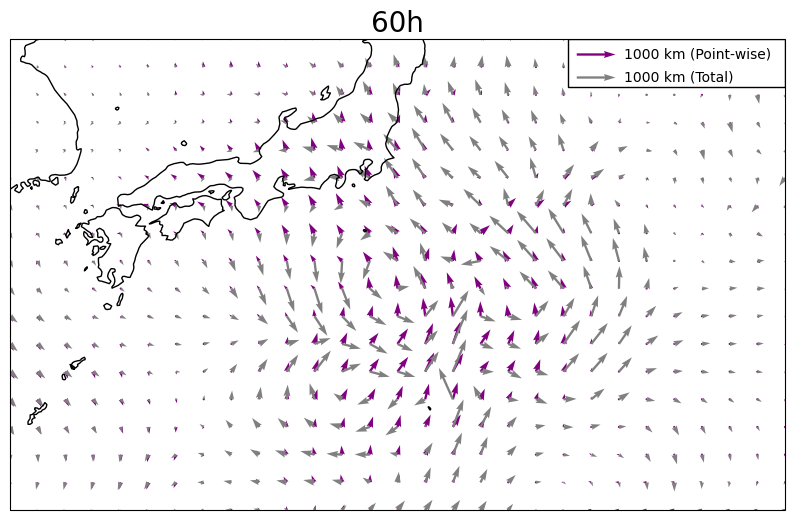

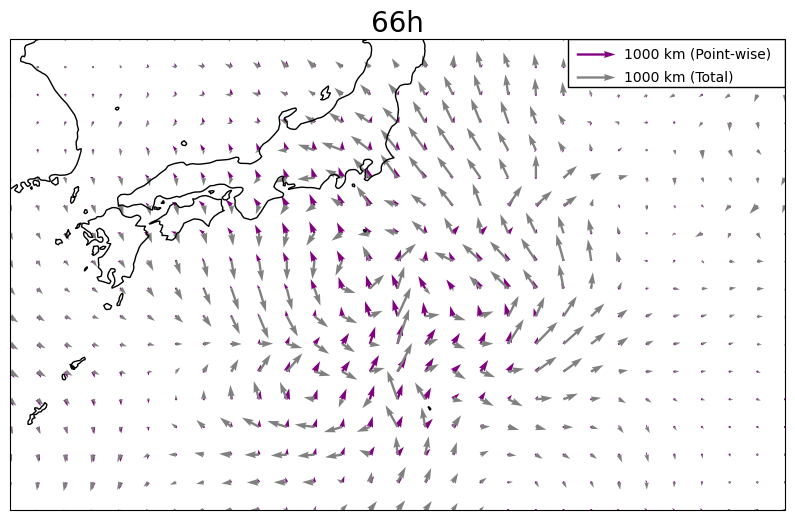

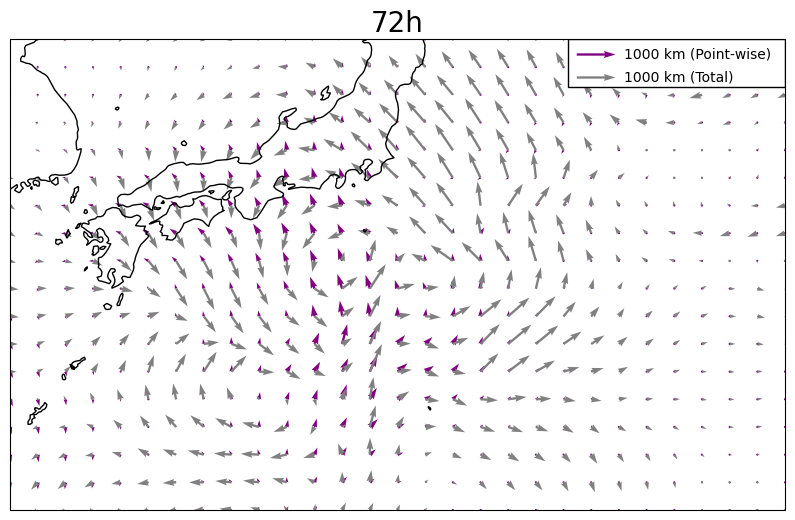

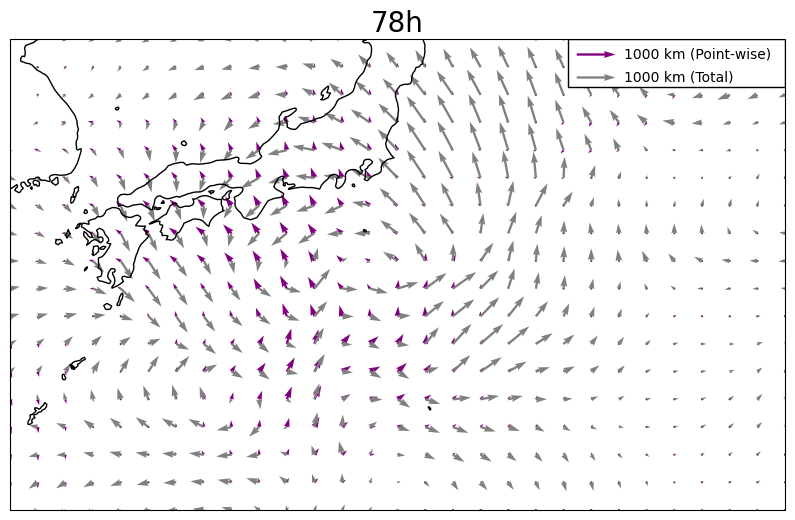

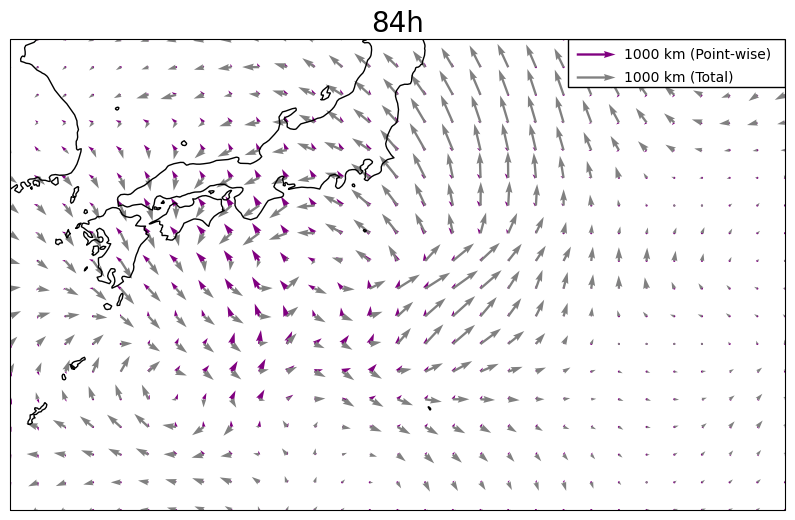

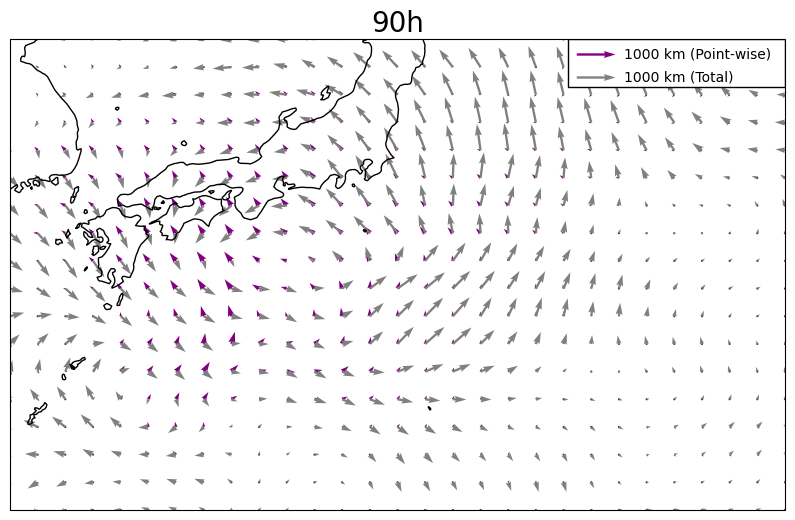

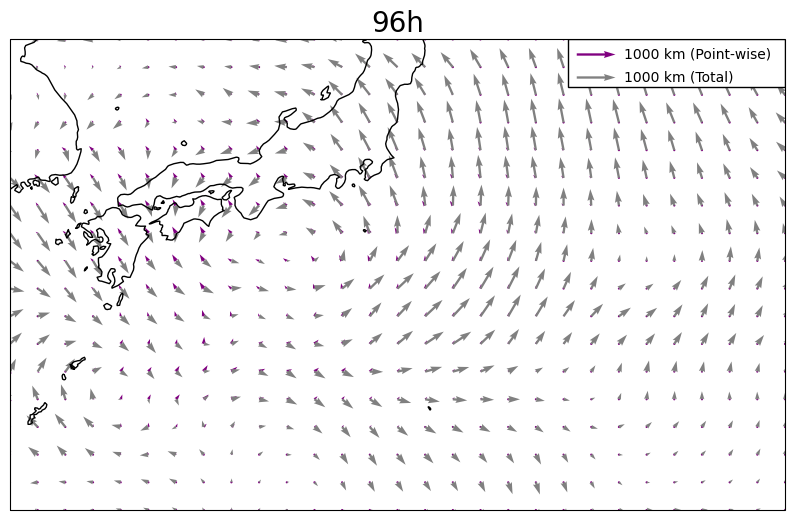

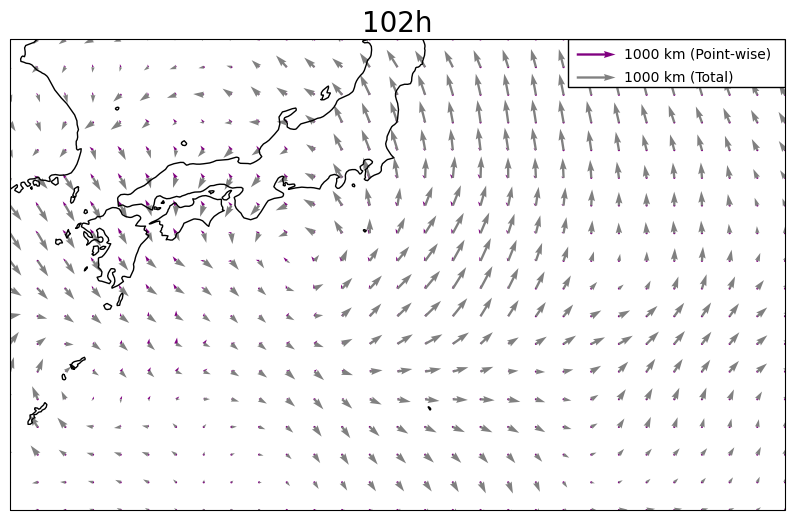

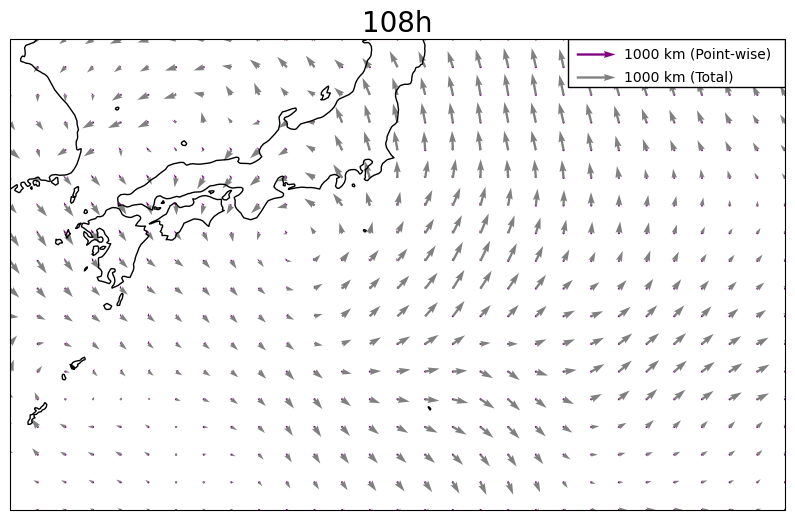

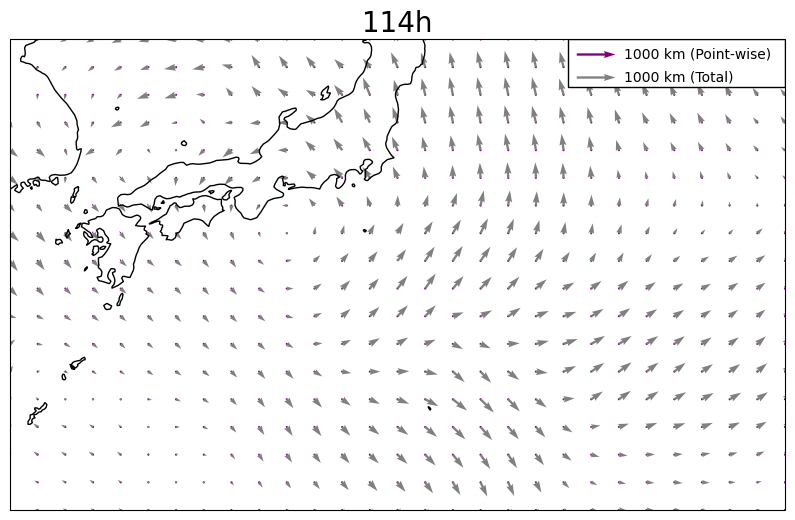

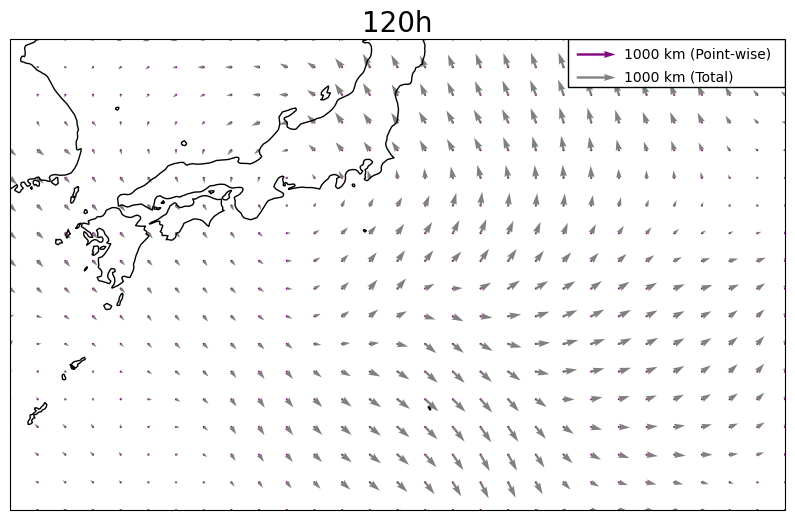

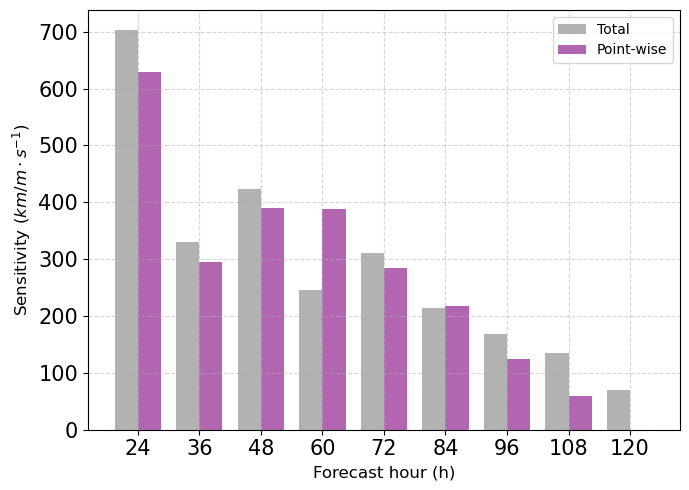

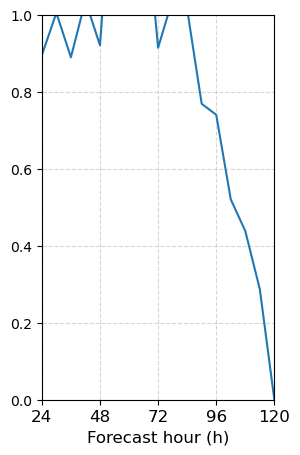

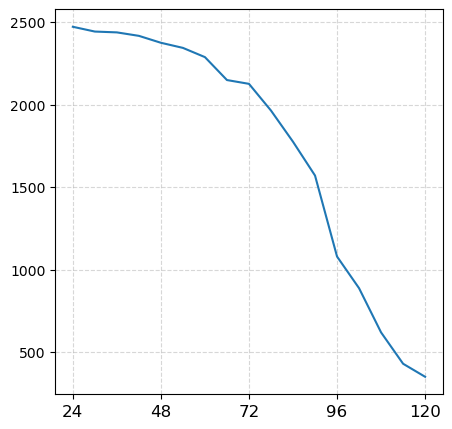

In [54]:
from matplotlib.patches import Rectangle

with open('/home1/jek/Pangu-Weather/output_data/cov_var/cov_var_pw.pkl', 'rb') as f:
    cov_var_nearby = pickle.load(f)
with open('/home1/jek/Pangu-Weather/output_data/cov_var/cov_var_conv.pkl', 'rb') as f:
    cov_var_convention = pickle.load(f)

key_time = datetime(2022,8,27,0)            #처음 시점 지정
start_time = datetime(2022,8,28,0)          #분석 시작 시점
target_time = datetime(2022,9,1,0)          #위치 projection을 구하고자 하는 시간

key_str = key_time.strftime("%m.%d %HUTC")
start_str = start_time.strftime("%m.%d %HUTC")
target_str = target_time.strftime("%m.%d %HUTC")

total_time_range = int((target_time - key_time).total_seconds() / 3600)
start_time_range = int((start_time  - key_time).total_seconds() / 3600)

# 변수 지정
nearby_sign = 'n'                           #가까운 태풍만 추출
distance_threshold = 0                      #가까운 태풍의 거리
steering_sign = 'y'                         #태풍 제거를 진행할 것인지를 판단(steering wind 진행)
steer_uni_alt = 0                           #steering wind를 구할 때, 고도를 하나
# choosen_factor_list = ['z','t','q']       #구하고자 하는 변수
choosen_factor_list = ['z']                 #구하고자 하는 변수
# altitude_list = [1000,850,700,500,300,200]#각 변수에 대해 구하고자 하는 고도
altitude_list = [850,500,250]               #각 변수에 대해 구하고자 하는 고도
steer_pres = [850,700,600,500,400,300,250]  #steering wind 구할 때 사용하는 고도 바꿀 필요 x
axis_opt = 'quiver'                         #axis 뭘로 잡을지, opt: 위치 상관관계 최대인 axis, tar: 최종 위치의 axis, mid: 중간 위치의 axis, lon: 경도, lat: 위도
data_sign = 'y'                             #기존의 데이터를 사용할 것인지, n이면 새로 구함

if nearby_sign == 'y':
    nearby_sign_name = '_nearby'
else:
    nearby_sign_name = ''
    

# steering_sign이 y면 steering wind에 대해서만 구하기
if steering_sign == 'y':
    altitude_list = ['850_200']
    choosen_factor_list = ['steering_wind']
    

ens_num_list = []
ens_not_list = []

for ens in ens_list:
    if (target_time in ssv_dict[key_time][ens]) and (start_time in ssv_dict[key_time][ens]):
        ens_num_list.append(ens)
    else:
        ens_not_list.append(ens)

print(len(ens_num_list), len(ens_not_list))


for predict_interval in np.arange(0,120+1,6):
    datetime1 = key_time + timedelta(hours=int(predict_interval))
    ens_num_list = []

    for ens in ens_list:
        if (datetime1 in ssv_dict[key_time][ens]):
            ens_num_list.append(ens)

    print(predict_interval, len(ens_num_list))


# target_time 때도 살아있는 태풍만 추출
ens_num_list = []

dir_all = {}
sensitivity_sum = []
con_mag_list = []
near_mag_list = []
diff_mag_list = []

size_list = []
for predict_interval in np.arange(start_time_range,total_time_range+1,6):
# for predict_interval in [24, ,72]:
    datetime1 = key_time + timedelta(hours=int(predict_interval))

    ens_num_list = []
    for ens in ens_list:
        if (target_time in ssv_dict[key_time][ens]) and (start_time in ssv_dict[key_time][ens]):
            ens_num_list.append(ens)

    mid_pos = [(ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']) for ens in ens_num_list]
    tar_pos = [(ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in ens_num_list]
    
    near_inner, near_inner_each, near_map = cov_var_nearby[predict_interval]['inner'], cov_var_nearby[predict_interval]['inner_each'], cov_var_nearby[predict_interval]['map']
    con_inner, con_map = cov_var_convention[predict_interval]['inner'], cov_var_convention[predict_interval]['map']

    np.shape(near_inner['u'])[0]
    size_list.append(np.shape(near_inner['u'])[0])
    
    near_vector = (np.mean(near_map['u'], axis = 0), np.mean(near_map['v'], axis = 0))
    con_vector  = (con_map['u'] , con_map['v'])
    diff_vector = (con_vector[0] - near_vector[0], con_vector[1] - near_vector[1]) 

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([127, 155, 23, 40], crs=ccrs.PlateCarree())
    ax.set_title(f'{predict_interval}h', fontsize=20, loc='center')

    # 파란색: Point-wise
    q1 = ax.quiver(
        lon_grid[::4, ::4], lat_grid[::4, ::4],
        np.mean(near_map['u'], axis=0)[::4, ::4],
        np.mean(near_map['v'], axis=0)[::4, ::4],
        color='purple', transform=ccrs.PlateCarree(), scale=20000, width=0.003
    )

    # 빨간색: Total
    q2 = ax.quiver(
        lon_grid[::4, ::4], lat_grid[::4, ::4],
        con_map['u'][::4, ::4], con_map['v'][::4, ::4],
        color='gray', transform=ccrs.PlateCarree(), scale=20000, width=0.003
    )

    # q3 = ax.quiver(
    #     lon_grid[::4, ::4], lat_grid[::4, ::4],
    #     diff_vector[0][::4, ::4], diff_vector[1][::4, ::4],
    #     color='blue', transform=ccrs.PlateCarree(), scale=20000, width=0.003
    # )

    # # 해안선
    ax.coastlines()

    # QuiverKey (길이: 500km 기준, U=500 설정)
    ax.add_patch(Rectangle((0.72, 0.9), 0.28, 0.1, transform=ax.transAxes,
                       facecolor='white', edgecolor='black', zorder=1))
    ax.quiverkey(q1, X=0.78, Y=0.97, U=1000, label='1000 km (Point-wise)', labelpos='E', color='purple')
    ax.quiverkey(q2, X=0.78, Y=0.92, U=1000, label='1000 km (Total)', labelpos='E', color='gray')

    plt.show()

    # fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': proj})
    # ax.set_title(f'{key_time.strftime("%Y-%m-%d-%HUTC")} (+{predict_interval}h)', fontsize=20, loc = 'left')
    # ax.quiver(lon_grid[::4,::4], lat_grid[::4,::4], near_vector[0][::4,::4], near_vector[1][::4,::4], color='pink',scale = 7000, width=0.002, transform=proj)
    # ax.quiver(lon_grid[::4,::4], lat_grid[::4,::4], con_vector[0][::4,::4], con_vector[1][::4,::4], color='orange',scale = 7000, width=0.002, transform=proj)
    # ax.quiver(lon_grid[::4,::4], lat_grid[::4,::4], diff_vector[0][::4,::4], diff_vector[1][::4,::4], color='blue',scale = 7000, width=0.002, transform=proj)
    # ax.coastlines(resolution='10m', color='black', linewidth=0.5, zorder=10)
    # ax.set_extent([125,155,20,35], crs=proj)
    # gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='-')
    # gl.top_labels = False
    # gl.right_labels = False
    # gl.xlabel_style = {'size': 12}
    # gl.ylabel_style = {'size': 12}

    # gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
    # gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
    # plt.show()
    
    near_inner_vector = (np.mean(near_inner['u']), np.mean(near_inner['v']))
    con_inner_vector  = (np.mean(con_inner['u']) , np.mean(con_inner['v']))
    diff_inner_vector = (con_inner_vector[0] - near_inner_vector[0], con_inner_vector[1] - near_inner_vector[1])


    near_mag = np.linalg.norm(near_inner_vector)
    # near_mag = np.linalg.norm(near_inner_vector)/(total_time_range - predict_interval+0.1)
    con_mag  = np.linalg.norm(con_inner_vector)
    diff_mag = np.linalg.norm(diff_inner_vector)

    near_mag_list.append(near_mag)
    con_mag_list.append(con_mag)
    diff_mag_list.append(diff_mag)


x = np.arange(start_time_range, total_time_range + 1, 6)

plt.figure(figsize=(7, 5))
bar_width = 4.5

x_12 = x[::2]
con_mag_12 = con_mag_list[::2]
near_mag_12 = near_mag_list[::2]
# x_12 = x
# con_mag_12 = con_mag_list
# near_mag_12 = near_mag_list
# diff_mag_12 = diff_mag_list

# plt.bar(x_12 , diff_mag_12, width=bar_width+1, alpha=0.6)
plt.bar(x_12 - bar_width/2, con_mag_12, width=bar_width, alpha=0.6, label='Total', color = 'gray')
plt.bar(x_12 + bar_width/2, near_mag_12, width=bar_width, alpha=0.6, label='Point-wise', color = 'purple')
# plt.bar(x + bar_width/2, diff_mag_list, width=bar_width, alpha=0.6, bottom=near_mag_list , label='difference')

# plt.xlabel('Forecast Hour')
# plt.ylabel('Magnitude')
# plt.title('Comparison of con_mag and near_mag over Time')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
xtick_vals = np.arange(start_time_range, total_time_range + 1, 12)
plt.xticks(xtick_vals, fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('Sensitivity ($km/m\cdot s^{-1}$)', fontsize = 12)
plt.xlabel('Forecast hour (h)', fontsize = 12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(3, 5))
plt.plot(x, list(map(lambda x, y: x/y, near_mag_list, con_mag_list)))
plt.grid(True, linestyle='--', alpha=0.5)
xtick_vals = np.arange(start_time_range, total_time_range + 1, 24)
plt.xticks(xtick_vals, fontsize = 12)
plt.ylim(0,1)
plt.xlim(start_time_range, total_time_range)
plt.xlabel('Forecast hour (h)', fontsize = 12)
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(x, size_list)
xtick_vals = np.arange(start_time_range, total_time_range + 1, 24)
plt.xticks(xtick_vals, fontsize = 12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [42]:
near_mag_list

[629.2641174519101,
 261.3904919133792,
 294.27345519044786,
 248.021384907609,
 389.6151167116096,
 417.9820300201032,
 388.32393931728376,
 328.842574430232,
 284.9334712151757,
 259.3794467780765,
 217.43011075343261,
 164.16683161036403,
 124.88372732057132,
 85.18077907046934,
 59.36910680655987,
 28.44822497518018,
 0.0]

In [25]:
np.shape(con_map['u'])

(161, 241)

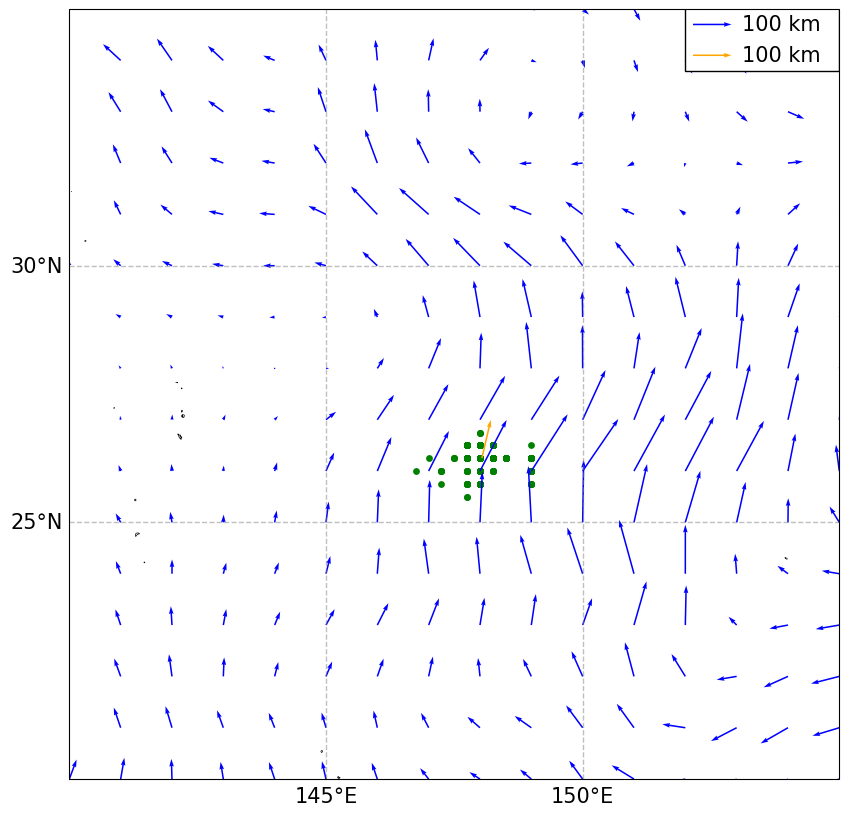

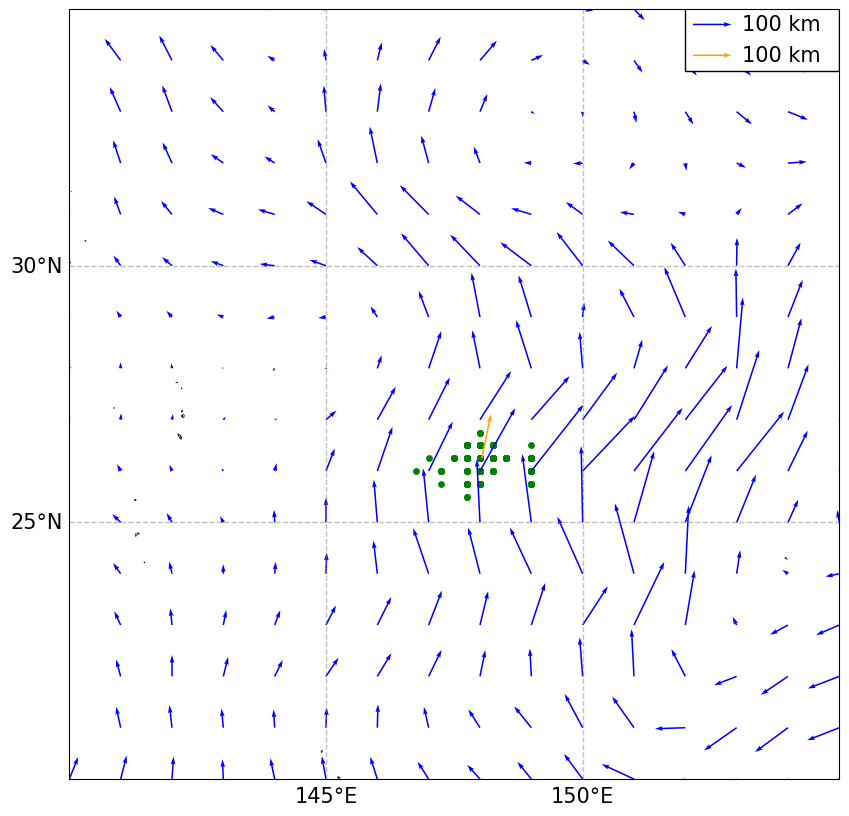

In [ ]:
near_vector ,con_vector  
import matplotlib.patches as patches
from matplotlib import font_manager

# 폰트 프로퍼티 설정
font_prop = font_manager.FontProperties(size=15)

qui_length = 100
fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': proj})
ax.set_extent([140,155,20,35], crs=proj)
ax.scatter(mid_pos[:,0], mid_pos[:,1], c='g', s=15, transform=proj)
ax.coastlines(resolution='10m', color='black', linewidth=0.5, zorder=10)
qui =ax.quiver(lon_grid[::4,::4], lat_grid[::4,::4], near_vector[0][::4,::4], near_vector[1][::4,::4], color='blue',scale = 2000, width=0.002, transform=proj)
key = ax.quiverkey(qui, X=0.86, Y=0.98, U=qui_length, label=f'{qui_length} km', labelpos='E', zorder=22, fontproperties=font_prop)
inner_qui = ax.quiver(np.mean(mid_pos[:,0]), np.mean(mid_pos[:,1]), near_inner_vector[0], near_inner_vector[1], color='orange',scale = 2000, width=0.002, transform=proj)
inner_key = ax.quiverkey(inner_qui, X=0.86, Y=0.94, U=qui_length, label=f'{int(qui_length)} km', labelpos='E', zorder=22, fontproperties=font_prop)

gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))

mid_pos = np.array(mid_pos)
rect = patches.Rectangle((0.80, 0.92), 0.2, 0.1, linewidth=1, edgecolor='black', facecolor='white', transform=ax.transAxes)
# rect = patches.Rectangle((0.84, 0.92), 0.16, 0.1, linewidth=1, edgecolor='black', facecolor='white', transform=ax.transAxes)
ax.add_patch(rect)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': proj})
ax.set_extent([140,155,20,35], crs=proj)
ax.scatter(mid_pos[:,0], mid_pos[:,1], c='g', s=15, transform=proj)
ax.coastlines(resolution='10m', color='black', linewidth=0.5, zorder=10)
qui =ax.quiver(lon_grid[::4,::4], lat_grid[::4,::4],con_vector[0][::4,::4], con_vector[1][::4,::4], color='blue',scale = 2000, width=0.002, transform=proj)
key = ax.quiverkey(qui, X=0.86, Y=0.98, U=qui_length, label=f'{qui_length} km', labelpos='E', zorder=22, fontproperties=font_prop)
inner_qui = ax.quiver(np.mean(mid_pos[:,0]), np.mean(mid_pos[:,1]), con_inner_vector[0], con_inner_vector[1], color='orange',scale = 2000, width=0.002, transform=proj)
inner_key = ax.quiverkey(inner_qui, X=0.86, Y=0.94, U=qui_length, label=f'{int(qui_length)} km', labelpos='E', zorder=22, fontproperties=font_prop)

gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))

mid_pos = np.array(mid_pos)
rect = patches.Rectangle((0.80, 0.92), 0.2, 0.1, linewidth=1, edgecolor='black', facecolor='white', transform=ax.transAxes)
ax.add_patch(rect)
plt.show()


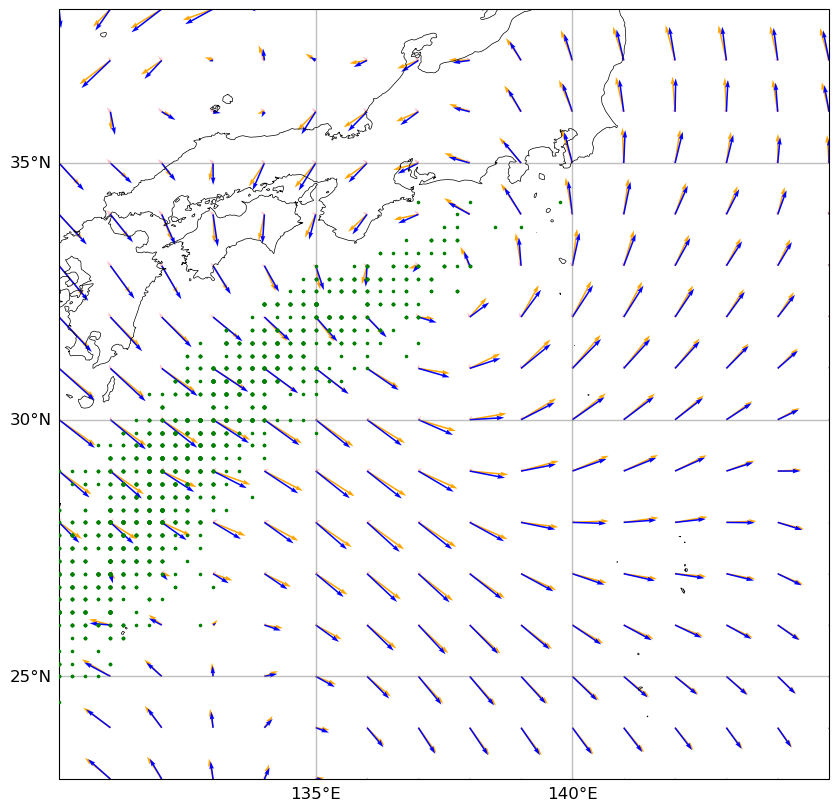

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': proj})
# ax.set_title(f'{key_time.strftime("%Y-%m-%d-%HUTC")} (+{predict_interval}h)', fontsize=20, loc = 'left')
mid_pos = np.array(mid_pos)
ax.scatter(mid_pos[:, 0], mid_pos[:, 1], alpha=1, s=2.5, c='green', zorder = 11)
ax.quiver(lon_grid[::4,::4], lat_grid[::4,::4], near_vector[0][::4,::4], near_vector[1][::4,::4], color='pink',scale = 7000, width=0.002, transform=proj)
ax.quiver(lon_grid[::4,::4], lat_grid[::4,::4], con_vector[0][::4,::4], con_vector[1][::4,::4], color='orange',scale = 7000, width=0.002, transform=proj)
ax.quiver(lon_grid[::4,::4], lat_grid[::4,::4], diff_vector[0][::4,::4], diff_vector[1][::4,::4], color='blue',scale = 7000, width=0.002, transform=proj)
ax.coastlines(resolution='10m', color='black', linewidth=0.5, zorder=10)
ax.set_extent([130,145,23,38], crs=proj)
# ax.set_extent([138,153,20,35], crs=proj)
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='-')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
plt.show()

In [26]:
mid_pos

[(142.75, 29.0),
 (142.5, 29.25),
 (143.0, 29.0),
 (143.25, 29.0),
 (142.25, 28.5),
 (143.25, 29.75),
 (143.25, 29.75),
 (142.75, 29.0),
 (142.5, 28.75),
 (142.75, 29.0),
 (142.25, 29.25),
 (143.75, 30.0),
 (143.25, 29.5),
 (143.0, 29.25),
 (143.25, 29.0),
 (143.25, 30.5),
 (142.75, 28.75),
 (142.75, 29.5),
 (143.0, 29.25),
 (142.25, 29.0),
 (143.25, 29.5),
 (143.25, 29.75),
 (142.5, 29.0),
 (142.75, 29.5),
 (142.75, 29.0),
 (143.0, 29.25),
 (143.25, 29.5),
 (142.0, 28.5),
 (142.5, 28.75),
 (142.75, 29.0),
 (142.5, 29.25),
 (142.25, 29.5),
 (142.25, 28.75),
 (142.75, 28.0),
 (142.75, 29.25),
 (142.75, 29.25),
 (142.75, 29.0),
 (142.75, 29.25),
 (143.25, 29.0),
 (143.25, 28.75),
 (142.75, 29.25),
 (143.25, 29.75),
 (142.5, 29.25),
 (142.25, 28.5),
 (142.25, 28.5),
 (143.25, 29.75),
 (142.5, 28.5),
 (142.0, 28.25),
 (142.75, 29.5),
 (142.75, 29.25),
 (142.25, 28.75),
 (142.75, 30.0),
 (142.5, 28.75),
 (143.25, 29.75),
 (142.25, 28.5),
 (142.75, 28.25),
 (142.75, 29.75),
 (142.75, 28.5),


In [9]:
np.shape(con_map['u'])

(161, 241)